In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

/home/fyh/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [3]:
write_gap(ResNet50, (224, 224))

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
write_gap(Xception, (299, 299), xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [6]:
write_gap(DenseNet201, (224, 224), densenet.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [7]:
write_gap(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [8]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [9]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

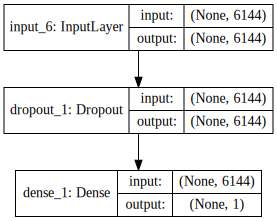

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 7s 336us/step - loss: 0.0810 - acc: 0.9722 - val_loss: 0.0185 - val_acc: 0.9956
Epoch 2/8
20000/20000 [==============================] - 1s 49us/step - loss: 0.0235 - acc: 0.9932 - val_loss: 0.0144 - val_acc: 0.9950
Epoch 3/8
20000/20000 [==============================] - 1s 48us/step - loss: 0.0178 - acc: 0.9949 - val_loss: 0.0144 - val_acc: 0.9946
Epoch 4/8
20000/20000 [==============================] - 1s 49us/step - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0111 - val_acc: 0.9970
Epoch 5/8
20000/20000 [==============================] - 1s 49us/step - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0097 - val_acc: 0.9968
Epoch 6/8
20000/20000 [==============================] - 1s 51us/step - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0094 - val_acc: 0.9966
Epoch 7/8
20000/20000 [==============================] - 1s 50us/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0101 - val_acc: 0.996

In [12]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)
print(y_pred)

12500/12500 [==============================] - 3s 276us/step
[[0.995]
 [0.005]
 [0.005]
 ...
 [0.995]
 [0.005]
 [0.005]]


In [13]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/fyh/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


Kaggle Score: 0.03891